# Value Estimation -- quadrature vs uniform

In [84]:
import math
from importlib import reload

import matplotlib.pyplot as plt
import pickle
import numpy as np

from tqdm.notebook import tqdm

from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time.environments import cartpole2
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

from pprint import pprint

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
cartpole2 = reload(cartpole2)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

In [7]:
utils.set_directory_in_project()

Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

## Load a goodish policy, generate data to process

Recall, we want:

1. The policy to stay up for ~10k steps, while we interact for 20k steps.
2. To generate trajectories from 100 different initial states.

We just need to store the fine grained rewards for each of these trajectories, all processing will happen on this after. 

In [8]:
GENERATE_NEW_DATA = False
SAVE_TRAJECTORIES = False
load_data_from = "many_good_trajs.pkl"


In [9]:
if GENERATE_NEW_DATA:
    seed = 13
    STEPS_MAX = 20_000
    STEPS_BREAK = 9_000
    NUM_TRAJS = 100

    from adaptive_time import mc2
    import adaptive_time.utils
    import gymnasium as gym
    import random

    env = gym.make('CartPole-OURS-v2', discrete_reward=True)
    _NUM_ACTIONS = 2

    phi = run_lib.make_features()

    weights_good_policy = np.load("cartpole_weights_20240227-102913_ret92516.44719752521.npy")

    # implement epsilon-greedy action sampling. 
    def policy(state, num_step, weights, epsilon):
        """Returns the action to take, and maybe the prob of all actions"""
        if num_step >= STEPS_BREAK:
            # If we are the the failing case, make this much more likely.
            epsilon = 0.06
        if random.random() < epsilon:
        # if random.random() < epsilon:
            action = env.action_space.sample()
            return action

        # Otherwise calculate the best action.
        x = phi.get_fourier_feature(state)
        qs = np.zeros(_NUM_ACTIONS)
        for action in range(_NUM_ACTIONS):
            x_sa = mc2.phi_sa(x, action)
            qs[action] = np.inner(x_sa.flatten(), weights)
        # adaptive_time.utils.softmax(qs, 1)
        
        return adaptive_time.utils.argmax(qs)

    run_lib.reset_randomness(seed, env)

    def _random_start_state(num):
        rand = np.random.standard_normal((num, 4))
        rand *= np.array([[0.01, 0.01, 0.001, 0.001]])
        return rand

    start_states = _random_start_state(NUM_TRAJS)
    print("shape", start_states.shape)
    print("max", np.max(start_states, axis=0))

    total_rewards = []
    reward_sequences = []
    traj_lengths = []
    for idx in range(NUM_TRAJS):
        start_state = tuple(start_states[idx])
        # Tuple[float, float, float, float]
        trajectory, early_term = value_est.generate_trajectory(
                env, start_state=start_state,
                policy=lambda st, sn: policy(st, sn, weights_good_policy, 0.0),
                termination_prob=0.0, max_steps=STEPS_MAX)

        traj_lengths.append(len(trajectory))
        rewards = [r for _, _, r, _ in trajectory]
        reward_sequences.append(rewards)
        total_rewards.append(sum(rewards))

    total_rewards = np.array(total_rewards)
    reward_sequences = np.array(reward_sequences)
    traj_lengths = np.array(traj_lengths)

    if SAVE_TRAJECTORIES:
        with open(load_data_from, "wb") as f:
            pickle.dump((total_rewards, reward_sequences, traj_lengths), f)
        print("Saved data to", load_data_from)

else:
    with open(load_data_from, "rb") as f:
        data = pickle.load(f)
    total_rewards, reward_sequences, traj_lengths = data

    print("Loaded data from", load_data_from)


print("total_rewards for each traj:", total_rewards)
print("all rewards shape:", reward_sequences.shape)
num_trajs = len(total_rewards)

Loaded data from many_good_trajs.pkl
total_rewards for each traj: [ 9564. 11828.  9723. 12029.  9441.  9283.  9515. 11781. 11517.  9112.
  9193. 10553.  9231. 13828.  9831. 11665.  9726.  9243.  9342.  9321.
  9844. 10532.  9465. 10929. 11433. 10190. 10488.  9660.  9078. 11085.
 10102.  9302.  9712. 10843.  9751. 10436. 10490. 10579.  9970. 10050.
 10328.  9921.  9765. 10185.  9596.  9825.  9045. 11476.  9417. 10730.
  9381. 11138.  9417.  9532.  9187. 11204.  9341.  9449. 10203. 10600.
 11353. 10876. 13146. 10028. 11178.  9332. 10300.  9229.  9746.  9073.
 10724.  9575. 10833.  9437.  9299. 12054.  9100.  9292. 10665.  9482.
 10504. 10365. 11089.  9422.  9607.  9611. 12038.  9754.  9168.  9108.
  9368. 10059.  9300. 11889. 10222. 10455.  9102.  9229.  9114.  9912.]
all rewards shape: (100, 20001)


## Data setup 2: the weights across initial states


In [10]:
seed = 43
run_lib.reset_randomness(seed, env=None)

weights = np.random.random((num_trajs,))
weights /= np.sum(weights)

print("weights:", weights)
print("sum:", np.sum(weights))

weights: [2.22313387e-03 1.17686459e-02 2.57743764e-03 4.64877622e-03
 6.32112168e-03 1.66006245e-02 1.28704819e-02 1.04565693e-02
 5.60617607e-04 1.41778005e-02 7.63139430e-03 1.54974997e-02
 4.91603453e-03 1.09915524e-03 1.67457582e-02 4.27081742e-03
 7.82538048e-03 6.10775211e-03 1.48130970e-03 1.62931506e-02
 1.64035677e-02 1.87710668e-02 7.44641866e-03 1.84430305e-02
 8.61313497e-03 1.29407081e-02 1.59410148e-03 1.73341250e-02
 5.75815194e-03 5.06836672e-03 9.91153555e-05 1.04959929e-02
 9.18967777e-03 1.22962862e-02 1.89012814e-02 1.75575730e-02
 1.75863696e-02 1.01492162e-02 2.00989893e-03 3.49570970e-03
 1.84150535e-02 7.95993291e-03 1.67142332e-02 1.29880988e-02
 1.21496699e-02 5.32446532e-03 1.73273368e-02 3.99764415e-03
 7.81409222e-03 1.91982355e-02 1.42160354e-02 8.59966823e-03
 1.08333752e-02 7.94645562e-03 1.40471750e-02 7.71345410e-03
 1.29488334e-02 1.36168184e-02 1.17781783e-02 1.04347784e-02
 3.98200225e-03 3.84828380e-03 1.53756089e-02 5.60993493e-03
 1.26747962e-02

## Learning

### Ground truth value

In [11]:
true_value = total_rewards @ weights
print("true value:", true_value)

true value: 10076.089908727237


### Learn from samples; with diff samplers

In [98]:
samplers_tried = dict(
    q100=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=100),
    q10=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=10),
    q1=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=1),
    q0=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=0),
    u1=approx_integrators.UniformlySpacedIntegrator(1),
    u10=approx_integrators.UniformlySpacedIntegrator(50),
    u100=approx_integrators.UniformlySpacedIntegrator(500),
    u5000=approx_integrators.UniformlySpacedIntegrator(5000),
)


Since everything other than the start state is deterministic, we can just calculate the approximate integrals for each trajectory with each integrator and store these.

In [99]:
approx_integrals = {}
num_pivots = {}

for sampler_name, sampler in tqdm(samplers_tried.items()):
    print("sampler_name:", sampler_name)
    approx_integrals[sampler_name] = []
    num_pivots[sampler_name] = []
    for idx, reward_seq in enumerate(reward_sequences):
        integral, all_pivots = sampler.integrate(reward_seq)
        approx_integrals[sampler_name].append(integral)
        num_pivots[sampler_name].append(len(all_pivots))
    approx_integrals[sampler_name] = np.array(approx_integrals[sampler_name])
    num_pivots[sampler_name] = np.array(num_pivots[sampler_name])



  0%|          | 0/8 [00:00<?, ?it/s]

sampler_name: q100
sampler_name: q10
sampler_name: q1
sampler_name: q0
sampler_name: u1
sampler_name: u10
sampler_name: u100
sampler_name: u5000


In [100]:
{k: v[0] for k, v in approx_integrals.items()}

{'q100': 9559.0,
 'q10': 9559.0,
 'q1': 9559.0,
 'q0': 9559.0,
 'u1': 9564.0,
 'u10': 9575.0,
 'u100': 9750.0,
 'u5000': 7500.0}

Now we just keep sampling the start state and integrate accordingly.

In [101]:
update_budget = 1_000_000

estimated_values_by_episode = {}
number_of_pivots_by_episode = {}
all_values_by_episode = {}

for sampler_name, sampler in tqdm(samplers_tried.items()):
    print("sampler_name:", sampler_name)
    # Update the value estimate with new samples until we run out of budget.
    used_updates = 0
    value_estimate = 0
    num_samples = 0
    all_values_by_episode[sampler_name] = []
    # empirical_state_distr = np.zeros((num_trajs))

    estimated_values_by_episode[sampler_name] = []
    number_of_pivots_by_episode[sampler_name] = []

    while used_updates < update_budget:
        num_samples += 1
        start_state = np.random.choice(num_trajs, p=weights)
        # empirical_state_distr[start_state] += 1
        val_sample = approx_integrals[sampler_name][start_state]
        all_values_by_episode[sampler_name].append(val_sample)
        
        value_estimate += (1.0/num_samples) * (val_sample - value_estimate)
        used_updates += num_pivots[sampler_name][start_state]

        estimated_values_by_episode[sampler_name].append(value_estimate)
        number_of_pivots_by_episode[sampler_name].append(used_updates)
    
    # empirical_state_distr /= np.sum(empirical_state_distr)
    # empirical_value = approx_integrals[sampler_name] @ empirical_state_distr


# CODE TO SAMPLE MANY TRAJECOTRIES TO FIND AN EMPIRICAL DISTRIBUTION 
# episode_samples = 100_000
# sampled_start_states = np.random.choice(num_trajs, size=(episode_samples,), p=weights)
# # We now have samples, we determine the empirical state distribution.
# empirical_state_distr = np.zeros((num_trajs))
# values, counts = np.unique(sampled_start_states, return_counts=True)
# empirical_state_distr[values] = counts
# empirical_state_distr /= np.sum(empirical_state_distr)


  0%|          | 0/8 [00:00<?, ?it/s]

sampler_name: q100
sampler_name: q10
sampler_name: q1
sampler_name: q0
sampler_name: u1
sampler_name: u10
sampler_name: u100
sampler_name: u5000


In [102]:
# Verify final means.
for key, value in estimated_values_by_episode.items():
    mean_total = np.mean(all_values_by_episode[key])
    mean_updated = value[-1]
    print("mean_total:", mean_total, "mean_updated:", mean_updated)
    if abs(mean_total - mean_updated) > 0.01:
        assert False, f"Means don't match for {key}: {mean_total} vs {mean_updated}"
    


mean_total: 10062.683944107566 mean_updated: 10062.68394410758
mean_total: 10064.439648365531 mean_updated: 10064.439648365531
mean_total: 10065.220467466836 mean_updated: 10065.220467466908
mean_total: 10069.191835012396 mean_updated: 10069.191835012482
mean_total: 9914.0 mean_updated: 9913.999999999998
mean_total: 10068.61489191353 mean_updated: 10068.614891913508
mean_total: 10104.224040174955 mean_updated: 10104.22404017491
mean_total: 9752.366981064151 mean_updated: 9752.36698106428


Text(0.5, 0, 'Number of Samples')

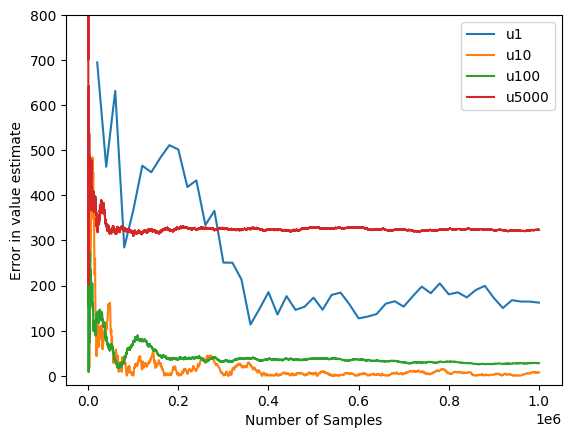

In [109]:
for s in samplers_tried.keys():
    if "q" in s:
        continue
    plt.plot(
        number_of_pivots_by_episode[s],
        np.abs(estimated_values_by_episode[s]-true_value),
        label=s)

plt.legend()
plt.ylabel("Error in value estimate")
plt.ylim(-20, 800)
plt.xlabel("Number of Samples")

Text(0.5, 0, 'Number of Samples')

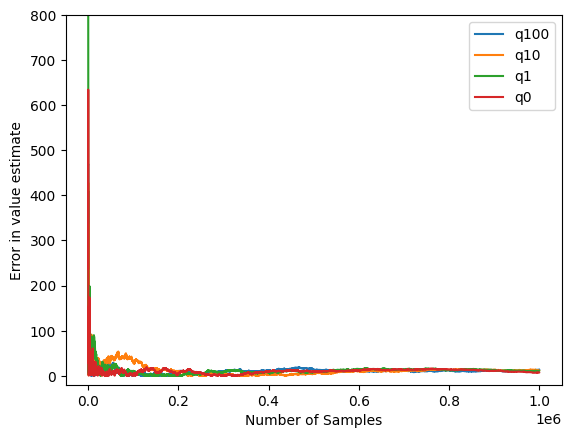

In [114]:
for s in samplers_tried.keys():
    if "q" not in s:
        continue
    plt.plot(
        number_of_pivots_by_episode[s],
        np.abs(estimated_values_by_episode[s]-true_value),
        label=s)

plt.legend()
plt.ylabel("Error in value estimate")
plt.ylim(-20, 800)
plt.xlabel("Number of Samples")

Text(0.5, 0, 'Number of Samples')

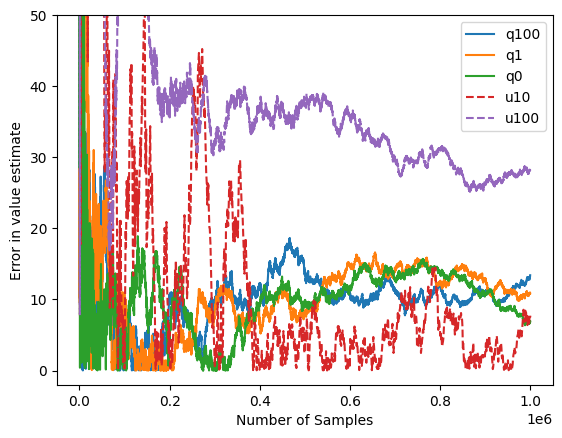

In [119]:
s_to_plot = ["q100", "q1", "q0", "u10", "u100"]
# for s in samplers_tried.keys():
for s in s_to_plot:
    linestyle = "-" if "q" in s else "--"
    plt.plot(
        number_of_pivots_by_episode[s],
        np.abs(estimated_values_by_episode[s]-true_value),
        label=s, linestyle=linestyle)

plt.legend()
plt.ylabel("Error in value estimate")
plt.ylim(-2, 50)
plt.xlabel("Number of Samples")